<a href="https://colab.research.google.com/github/AmirhassanRahmani/amirkabir/blob/main/Advance_BLER_Rate_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NN_Polar_Decoder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import gc
gc.collect(generation=2)

88

**Parameters**

In [2]:
N = 64
flip_prob = 0.3  # BSC flip probability

**shannon capacity**

In [3]:
p = flip_prob
# Binary entropy function
def binary_entropy(p):
    if p == 0 or p == 1:
        return 0.0
    return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

# Channel capacity for BSC
C = 1 - binary_entropy(p)
print(f'C: {C}')

C: 0.1187091007693073


**Polyanskiy, Poor, Verdu´**

In [4]:
from scipy.stats import norm
epsilon = 0.1

# Channel dispersion for BSC
V = p * (1 - p) * (np.log2((1 - p) / p))**2

# Q inverse (using normal inverse CDF)
Qinv = norm.ppf

# Normal approximation for finite blocklength capacity
R_star = C - np.sqrt(V / N) * Qinv(1 - epsilon) + np.log2(N) / (2 * N)
R_star = R_star.item()
K_star = R_star * N
Round_K_star = round(K_star)

print(f'R_star: {R_star}')
print(f'K_star: {K_star}')

R_star: 0.07584816530250046
K_star: 4.85428257936003


**Polar Encoder (Bhattacharyya)**

In [5]:
# Define Polar Encoder (Bhattacharyya approximation for BSC)
def polarization_channel_bsc(N, k, flip_prob):
    z0 = np.zeros(N)
    z0[0] = 2 * np.sqrt(flip_prob * (1 - flip_prob))
    n = int(np.log2(N))
    for j in range(1, n + 1):
        u = 2 ** j
        for t in range(0, u // 2):
            T = z0[t]
            z0[t] = 2 * T - T**2
            z0[u // 2 + t] = T**2
    idx = np.argsort(z0)
    A = np.zeros(N, dtype=bool)
    A[idx[0:k]] = True
    return A


In [6]:
def polar_xor_encoding(u):
    x = np.copy(u)
    stages = int(np.log2(len(u)))
    for s in range(stages):
        n = 2 ** s
        for i in range(0, len(u), 2 * n):
            for j in range(n):
                x[i + j] ^= x[i + j + n]
    return x

In [7]:
u = np.array([1,1,1,1])
result = polar_xor_encoding(u)
result

array([0, 0, 0, 1])

## Build Torch NN Training Model

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class DNN_Model(nn.Module):
    def __init__(self, k):
        super(DNN_Model, self).__init__()
        self.k = k
        self.fcnn1 = nn.Linear(N, 1500)                  # 第1層 Linear NN
        self.fcnn2 = nn.Linear(1500, 1500)                # 第2層 Linear NN
        self.fcnn3 = nn.Linear(1500, 1200)                 # 第3層 Linear NN
        self.fcnn4 = nn.Linear(1200, 1000)                 # 第3層 Linear NN
        self.output = nn.Linear(1000, k)                  # 第4層 Linear NN
        # nn.init.kaiming_normal_(self.fcnn2.weight, mode='fan_in')
        # nn.init.normal_(self.fcnn4.bias, mean=0.0, std=0.1)

    def forward(self, input_layer):
        x = F.relu(self.fcnn1(input_layer))
        x = F.relu(self.fcnn2(x))
        x = F.relu(self.fcnn3(x))
        x = F.relu(self.fcnn4(x))
        predi_output = torch.sigmoid(self.output(x))
        return predi_output



**Training Model**

In [10]:
# create your optimizer
loss_function = nn.MSELoss()

def mini_batch_loss(model, optimizer, x, target):
    model.train()
    optimizer.zero_grad()
    x_tensor = torch.tensor(x, dtype=torch.float32)
    y_tensor = torch.tensor(target, dtype=torch.float32)
    output = model(x_tensor)
    loss = loss_function(output, y_tensor)
    loss.backward()
    optimizer.step()
    return loss.item()



In [11]:
def build_data(k):
    np.random.seed(4267)
    info_codewords = np.random.randint(0, 2, size=(samples_size, k))
    A = polarization_channel_bsc(N, k, flip_prob)
    polar_codewords = np.zeros((samples_size, N), dtype=int)
    u = np.zeros((samples_size, N), dtype=int)
    u[:, A] = info_codewords
    for i in range(samples_size):
        polar_codewords[i] = polar_xor_encoding(u[i])
    return polar_codewords, info_codewords

def simulate_bsc_noise(x, flip_prob):
    flips = np.random.binomial(1, flip_prob, size=x.shape)
    return x ^ flips

In [12]:
from datetime import datetime

# Improved Checkpoint Manager
class CheckpointManager:
    def __init__(self, base_dir="polar_decoder_checkpoints"):
        self.base_dir = base_dir
        os.makedirs(base_dir, exist_ok=True)

    def get_best_checkpoint_path(self, k):
        """Returns path to the best checkpoint for given k"""
        pattern = f"polar_decoder_k{k}_e*.pt"
        checkpoints = [f for f in os.listdir(self.base_dir) if f.startswith(f"polar_decoder_k{k}_")]

        if not checkpoints:
            return None

        # Find checkpoint with lowest BLER
        best_checkpoint = None
        best_bler = float('inf')

        for cp in checkpoints:
            try:
                bler = float(cp.split('_bler')[1].split('.pt')[0])
                if bler < best_bler:
                    best_bler = bler
                    best_checkpoint = cp
            except:
                continue

        return os.path.join(self.base_dir, best_checkpoint) if best_checkpoint else None

    def save_checkpoint(self, model, optimizer, k, epoch, loss, bler):
        """Saves checkpoint with BLER in filename"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        checkpoint_path = os.path.join(
            self.base_dir,
            f"polar_decoder_k{k}_e{epoch}_bler{bler:.5f}_{timestamp}.pt"
        )

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            'bler': bler,
            'k': k
        }, checkpoint_path)

        print(f"Saved checkpoint: BLER={bler:.5f} at {checkpoint_path}")
        return checkpoint_path

# Modified Training Loop
checkpoint_mgr = CheckpointManager()

In [13]:
samples_size = 128000
training_batch = int(samples_size * 0.8)
valid_batch = int(samples_size * 0.2)
mini_batch = 512
total_iterations = training_batch // mini_batch

bler_list = []
rate_list = []
k_list = [1,2,3,4,5,6,7,8,9,10]


for k in k_list:
    print(f"\n{'='*40}\nTraining for k = {k}\n{'='*40}")

    decoder = DNN_Model(k)
    optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

    # Load best existing checkpoint if available
    best_checkpoint_path = checkpoint_mgr.get_best_checkpoint_path(k)
    if best_checkpoint_path:
        checkpoint = torch.load(best_checkpoint_path)
        decoder.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_bler = checkpoint['bler']
        print(f"Resuming from best checkpoint: BLER={best_bler:.5f} (epoch {checkpoint['epoch']})")
    else:
        start_epoch = 0
        best_bler = float('inf')

    polar_codewords, info_codewords = build_data(k)
    epochs = 15 if k >= 4 else 5  # Your original epoch scheme

    for epoch in range(start_epoch, start_epoch + epochs):
        total_loss = 0
        for i in range(total_iterations):
            x = i * mini_batch
            y = (i + 1) * mini_batch
            noisy_input = simulate_bsc_noise(polar_codewords[x:y], flip_prob)
            loss = mini_batch_loss(decoder, optimizer, noisy_input, info_codewords[x:y])
            total_loss += loss

        avg_loss = total_loss / total_iterations

        # Evaluation
        noisy_input = simulate_bsc_noise(polar_codewords, flip_prob)
        decoder.eval()
        with torch.no_grad():
            pred = decoder(torch.tensor(noisy_input, dtype=torch.float32))
        pred_bin = (pred > 0.5).float()
        errors = (pred_bin != torch.tensor(info_codewords, dtype=torch.float32)).float()
        block_errors = errors.view(samples_size, k).sum(dim=1) > 0
        current_bler = block_errors.float().sum().item() / samples_size

        # Save if improved
        if current_bler < best_bler:
            best_bler = current_bler
            checkpoint_mgr.save_checkpoint(decoder, optimizer, k, epoch+1, avg_loss, best_bler)

        print(f"Epoch {epoch+1}/{start_epoch + epochs}: Loss={avg_loss:.4f}, BLER={current_bler:.5f} (Best={best_bler:.5f})")

    # Store final results
    bler_list.append(best_bler)
    rate_list.append(k/N)


Training for k = 1
Saved checkpoint: BLER=0.00100 at polar_decoder_checkpoints/polar_decoder_k1_e1_bler0.00100_20250513_074101.pt
Epoch 1/5: Loss=0.0162, BLER=0.00100 (Best=0.00100)
Saved checkpoint: BLER=0.00088 at polar_decoder_checkpoints/polar_decoder_k1_e2_bler0.00088_20250513_074233.pt
Epoch 2/5: Loss=0.0007, BLER=0.00088 (Best=0.00088)
Saved checkpoint: BLER=0.00066 at polar_decoder_checkpoints/polar_decoder_k1_e3_bler0.00066_20250513_074405.pt
Epoch 3/5: Loss=0.0007, BLER=0.00066 (Best=0.00066)
Epoch 4/5: Loss=0.0007, BLER=0.00091 (Best=0.00066)
Epoch 5/5: Loss=0.0006, BLER=0.00083 (Best=0.00066)

Training for k = 2
Saved checkpoint: BLER=0.02113 at polar_decoder_checkpoints/polar_decoder_k2_e1_bler0.02113_20250513_074915.pt
Epoch 1/5: Loss=0.0450, BLER=0.02113 (Best=0.02113)
Epoch 2/5: Loss=0.0118, BLER=0.02145 (Best=0.02113)
Epoch 3/5: Loss=0.0121, BLER=0.02255 (Best=0.02113)
Saved checkpoint: BLER=0.01958 at polar_decoder_checkpoints/polar_decoder_k2_e4_bler0.01958_20250513

In [14]:
bler_list

[0.0006640625,
 0.019578125,
 0.0518125,
 0.0932578125,
 0.156515625,
 0.2275859375,
 0.408390625,
 0.753140625,
 0.909765625,
 0.9639375]

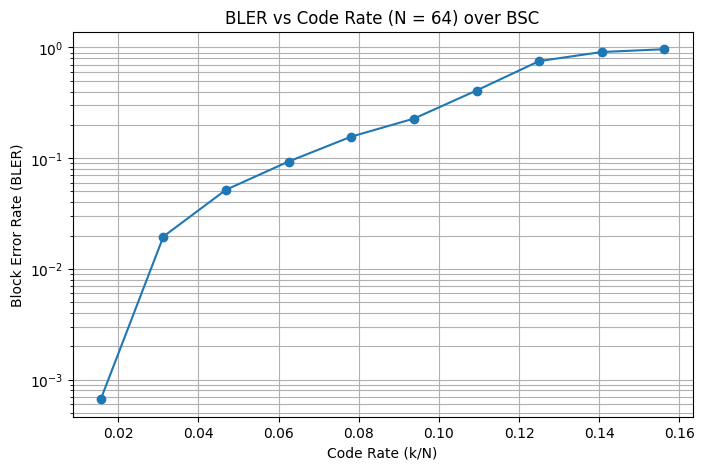

In [15]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(8, 5))
plt.semilogy(rate_list, bler_list, marker='o', linestyle='-')
plt.xlabel("Code Rate (k/N)")
plt.ylabel("Block Error Rate (BLER)")
plt.title(f"BLER vs Code Rate (N = {N}) over BSC")
plt.grid(True, which="both")
plt.show()
